# Introduction

This example demonstrates how to convert a network from [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) for use with Lasagne. We will be using the Lenet trained for MNIST.

We will create a set of Lasagne layers corresponding to the Caffe model specification (prototxt), then copy the parameters from the caffemodel file into our model.

# Converting from Caffe to Lasagne
### Download the required files

First we download `cifar10_nin.caffemodel` and `model.prototxt`. The supplied `train_val.prototxt` was modified to replace the data layers with an input specification, and remove the unneeded loss/accuracy layers.

### Import Caffe

To load the saved parameters, we'll need to have Caffe's Python bindings installed.

In [1]:
import sys
caffe_root = '/home/xilinx/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import caffe

### Load the pretrained Caffe network

In [2]:
net_caffe = caffe.Net('lenet.prototxt', 'lenet_iter_10000.caffemodel', caffe.TEST)

### Import Lasagne

In [4]:
import lasagne
from lasagne.layers import InputLayer, DropoutLayer, DenseLayer, NonlinearityLayer
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify, linear
import conv_fpga
from conv_fpga import FPGA_LENET
from conv_fpga import FPGAQuickTest
#from conv_fpga import Conv2DLayer as ConvLayer
from conv_fpga import FPGAWeightLoader as FPGALoadW
from lasagne.utils import floatX

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


### Create a Lasagne network
Layer names match those in `model.prototxt`

In [5]:
net = {}
net['input'] = InputLayer((None, 1, 28, 28))
net['conv1'] = ConvLayer(net['input'], num_filters=20, filter_size=5, nonlinearity=linear)
net['pool1'] = PoolLayer(net['conv1'], pool_size=2, stride=2, mode='max', ignore_border=False)
net['conv2'] = ConvLayer(net['pool1'], num_filters=50, filter_size=5, nonlinearity=linear)
net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, mode='max', ignore_border=False)
net['ip1'] = DenseLayer(net['pool2'], num_units=500, nonlinearity = rectify)
net['ip2'] = DenseLayer(net['ip1'], num_units=10, nonlinearity = None)
net['prob'] = NonlinearityLayer(net['ip2'], softmax)

### Copy the parameters from Caffe to Lasagne

In [6]:
import numpy as np

layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))

for name, layer in net.items():
    try:
        if name=='ip1'or name=='ip2':
            layer.W.set_value(np.transpose(layers_caffe[name].blobs[0].data))
            layer.b.set_value(layers_caffe[name].blobs[1].data)
        else:
            layer.W.set_value(layers_caffe[name].blobs[0].data[:,:,::-1,::-1])
            layer.b.set_value(layers_caffe[name].blobs[1].data)
            
    except AttributeError:
        continue

### Copy the parameters from CPU to FPGA OnChip Memory

In [7]:
#FPGALoadW(weight, status, IFDim, OFDim, PadDim)
weight = net['conv1'].W.get_value()
FPGALoadW(weight, 1, 28, 24, 0)
weight = net['conv2'].W.get_value()
FPGALoadW(weight, 2, 12, 8, 0)
weight = net['ip1'].W.get_value()
weight = np.transpose(weight)
weight = weight.reshape(500, 50, 4, 4)
FPGALoadW(weight, 3, 4, 1, 0, flip_filters=False)
weight = net['ip2'].W.get_value()
weight = np.transpose(weight)
weight = weight.reshape(10, 500, 1, 1)
FPGALoadW(weight, 4, 1, 1, 0, flip_filters=False)

weight shape (20, 1, 5, 5)
Loading Started for Layer  1
Elapsed Test Time:  0.0005476130000019452
(508,)
Loading Finished for Layer  1
weight shape (50, 20, 5, 5)
Loading Started for Layer  2
Elapsed Test Time:  0.004208054999999433
(25008,)
Loading Finished for Layer  2
weight shape (500, 50, 4, 4)
Loading Started for Layer  3


/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


Elapsed Test Time:  0.010845512999999585
(400008,)
Loading Finished for Layer  3
weight shape (10, 500, 1, 1)
Loading Started for Layer  4
Elapsed Test Time:  0.0035060120000025563
(5008,)
Loading Finished for Layer  4


# Trying it out
Let's see if that worked. 

### Import numpy and set up plotting
### Import time

In [8]:
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import time

%matplotlib inline

### Download some test data
Load test mnist handwritting data.

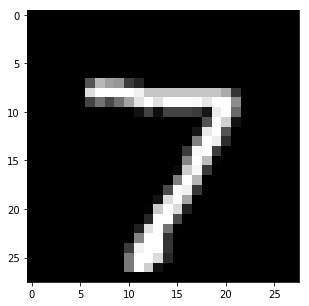

In [9]:
data = np.load('test_cpr.npz')
test_data = data['data'].reshape(10000, 1, 28, 28)
test_label = data['label']
##
plt.figure(figsize=(5, 5))
plt.imshow(test_data[0][0], interpolation='nearest', cmap=plt.get_cmap('gray'))

### FPGA Deployment (Lasagne Layer)

In [10]:
FPGA_net = {}
FPGA_net['input'] = InputLayer((None, 1, 28, 28))
FPGA_net['lenet'] = FPGA_LENET(FPGA_net['input'])
FPGA_net['prob'] = NonlinearityLayer(FPGA_net['lenet'], softmax)

In [11]:
batch_size = 500

%time prob = lasagne.layers.get_output(FPGA_net['prob'], floatX(test_data[0:batch_size]), deterministic=True).eval()
FPGA_predicted = np.argmax(prob, 1)

Elapsed Test Time:  0.6721462430000003
(5008,)
CPU times: user 1.22 s, sys: 289 ms, total: 1.51 s
Wall time: 3.22 s


In [12]:
FPGA_accuracy = np.mean(FPGA_predicted == test_label[0][0:batch_size])
#print(FPGA_predicted)
#print(test_label[0][0:600])
print(FPGA_accuracy)

0.984


### FPGA Deployment (QuickTest Function)

In [13]:
batch_size = 600

OFMDim = 1
OFMCH = 10
%time FPGA_output = FPGAQuickTest(test_data, batch_size, OFMDim, OFMCH)
FPGA_predicted = np.argmax(FPGA_output.reshape(batch_size, -1), 1)

Elapsed Test Time:  0.8062666600000057
(6008,)
CPU times: user 870 ms, sys: 68.2 ms, total: 938 ms
Wall time: 934 ms


In [14]:
FPGA_accuracy = np.mean(FPGA_predicted == test_label[0][0:batch_size])
print(FPGA_accuracy)

0.983333333333


### Graph some images and predictions

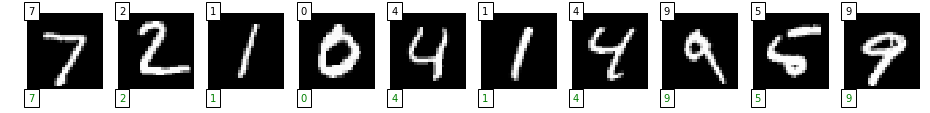

In [15]:
def make_image(X):
    im = np.swapaxes(X.T, 0, 1)
    im = im - im.min()
    im = im * 1.0 / im.max()
    return im

plt.figure(figsize=(16, 5))
for i in range(0, 10):
    plt.subplot(1, 10, i+1)
    plt.imshow(make_image(test_data[i][0]), interpolation='nearest', cmap=plt.get_cmap('gray'))
    true = test_label[0][i]
    pred = FPGA_predicted[i]
    color = 'green' if true == pred else 'red'
    plt.text(0, 0, true, color='black', bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 32, pred, color=color, bbox=dict(facecolor='white', alpha=1))

    plt.axis('off')

### ARM CPU Deployment

In [16]:
batch_size = 600
%time prob = np.array(lasagne.layers.get_output(net['prob'], floatX(test_data[0:batch_size]), deterministic=True).eval())
predicted = np.argmax(prob, 1)

/usr/local/lib/python3.6/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


CPU times: user 10.5 s, sys: 1.16 s, total: 11.7 s
Wall time: 33.6 s


### Check our accuracy
We expect around 90%

In [17]:
accuracy = np.mean(predicted == test_label[0][0:batch_size])
# print(predicted)
# print(test_label[0][0:batch_size])
print(accuracy)

0.985
